### HW1

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy
from tqdm.notebook import tqdm

In [2]:
def data_loader(file_name):
    mat = scipy.io.loadmat(file_name)
    Xtrain = mat.get('Yt')
    # for the bias
    Xtrain = np.vstack([Xtrain, np.ones(Xtrain.shape[1])]) 
    Ytrain = mat.get('Ct').T
    Xtest = mat.get('Yv')
    Xtest = np.vstack([Xtest, np.ones(Xtest.shape[1])])
    Ytest = mat.get('Cv').T
    return Xtrain, Ytrain, Xtest, Ytest

datasets = ["GMMData","PeaksData","SwissRollData"]
Xtrain, Ytrain, Xtest, Ytest = data_loader(datasets[0])

# Solutions

## Part I
### 1.

In this block we implemented the softmax, the softmax loss and the softmax gradient.\
The parameters:

X - train data of shape (features, observations)\
w - weights dataset of shape (features, labels)\
C - the label data (observations, labels)\
eta - softmax stabilizier

In [3]:
def softmax(X, w, eta = True):
    product_Xw = X.T @ w
    if eta==True:
        exp = np.exp(product_Xw - np.max(product_Xw ))
    else:
        exp = np.exp(product_Xw )
    div = np.divide(exp, np.sum(exp, axis = 1).reshape(-1,1))
    return div

def softmax_loss(X, C, w, eta = True):
    sm = softmax(X, w, eta = eta)
    log  = np.log(sm)
    m = len(X[0])
    return -np.sum(C*log)/m  

def softmax_gradient(X, C, w, eta = True):
    sm= softmax(X, w, eta = eta)
    m = len(X[0])
    gradient = (1/m)*X @ (sm - C)
    return gradient

Here we check the correctness of the code written above with a gradinet test technique.

In [4]:
def gradient_test(X,C):
    # number of dimensions (features)
    n = X.shape[0]
    # number of labels
    l = C.shape[1]

    
    d = np.random.rand(n,l)
    d = d/np.linalg.norm(d,ord = 1, axis = 0)
    w = np.random.rand(n,l)
    
    loss = softmax_loss(X, C, w, eta = True)
    grad = softmax_gradient(X, C, w, eta = True)
    
    comp1 = []
    comp2 = []
    eps_list = []
    
    eps = 0.5
    test_range = list(range(20))
    for i in test_range:
        loss_d = softmax_loss(X, C, w + eps*d , eta = True)
        comp1.append(abs(loss_d  - loss ) )
        comp2.append(abs(loss_d  - loss - (d * eps).ravel() @ grad.ravel()))
        eps_list.append(eps)
        eps *= 0.5

    plt.plot(test_range,comp1,color = 'r')
    plt.plot(test_range,comp2, color = 'g')
    plt.legend(["without gradients ", "with gradients "])
    plt.xlabel('eps')
    plt.ylabel('output value')
    plt.yscale('log')
    plt.xticks( range(len(eps_list)),eps_list,rotation = 45)
    plt.show()

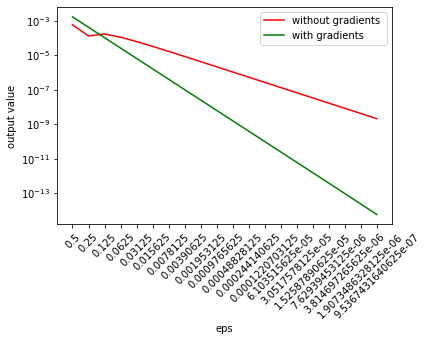

In [5]:
gradient_test(Xtrain ,Ytrain)

### 2&3 SGD

In this section, we implement SGD. We measure the value of the loss function and the accuracy at each epoch. This allows us to show that we have reached a minimum error , and maximum accuracy as expected, the loss and is being reduced by the optimization algorithm.

In [6]:
np.random.seed(2022)
def f():    
    print(np.random.randn())
    print(np.random.shuffle([1,2,3,4,5]))
f()

-0.0005278990859607484
None


In [7]:
arr = np.arange(10)
np.random.shuffle(arr)
arr

array([3, 6, 9, 4, 1, 5, 7, 0, 2, 8])

In [8]:
def least_squares_loss(x,y,w):
    pred_labels = np.argmax(softmax(x,w),axis=1)
    true_labels = y.argmax(axis=1)
    loss = np.linalg.norm(true_labels-pred_labels,2)**2
    return loss

def accuracy(x, y, w):
    pred_labels = np.argmax(softmax(x,w),axis=1)
    true_labels = y.argmax(axis=1)
    return np.count_nonzero(true_labels == pred_labels) / x.shape[1]

In [9]:
def sgd(dataset , lr , batch_size, epochs=10, to_plot=False):
    Xtrain, Ytrain, Xtest, Ytest = dataset
    feature_num, examples_num = Xtrain.shape
    labels_num = Ytrain.shape[1]
    
    train_acc=[]
    test_acc=[]
    train_loss = []
    
    # Initialize weights
    w = np.random.randn(feature_num, labels_num)
    
    # Train loop
    for epoch in tqdm(range(epochs)):
        # Shuffle train data
        indices = np.arange(examples_num)
        np.random.shuffle(indices)
        print(len(indices))
        Xtrain = Xtrain[:, indices]
        Ytrain = Ytrain[indices, :]
        i = 0
        while i * batch_size < examples_num:
            # Obtain minibatch
            batch_start = i * batch_size
            batch_end = min((i + 1) * batch_size, examples_num)
            minix = Xtrain[:, batch_start:batch_end]
            miniy = Ytrain[batch_start:batch_end, :]
            
            # Update weights
            grad = softmax_gradient(minix, miniy, w,False)
            w -= lr * grad
            i += 1
            
        # Calculate accuracies
        train_accuracy = accuracy(Xtrain, Ytrain, w)
        test_accuracy = accuracy(Xtest, Ytest, w)
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
        train_loss.append(least_squares_loss(Xtrain,Ytrain,w))
            
            
    if to_plot:
        fig, (ax1, ax2) = plt.subplots(1, 2,constrained_layout=True,figsize=(9,8))
        
        xs = range(epochs)
        # Plot
        ax1.plot(xs, train_acc)
        ax1.plot(xs, test_acc)
        # Set y-axis parameters
        ax1.set_yticks(np.arange(round(min(train_acc + test_acc), 2), 0.6, 0.05))
        ax1.set_ylabel('Accuracy %', size=12)
        # Set x-axis parameters
        ax1.set_xlabel('Epochs', size=12)
        ax1.set_xticks(xs)
        # Title and show
        ax1.set_title(f'SGD (lr={lr} batch size={batch_size})')
        ax1.legend(['Train set', 'Test set'], loc='best')
        
        ax2.semilogy(train_loss)
        ax2.legend(['Train loss'])
        ax2.set_title(f'Square error loss')
        ax2.set_ylabel('Loss', size=12)
        ax2.yaxis.set_label_position("right")
        ax2.set_xlabel('Epochs',size=12)
        ax2.set_xticks(xs)
        plt.show()
    
        

In our experiments we tested different parameters in for obtaining global minimum.
We got to conclusion that there needed to be alot of fine tuning to batch size and the learning rate.
notice that since these datasets represent a non-linear problems,we expect our model be bad at this problems.
* for GMM we got around 50% accuracy.
* for Peaks we got around 60% accuracy.

  0%|          | 0/20 [00:00<?, ?it/s]

25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000


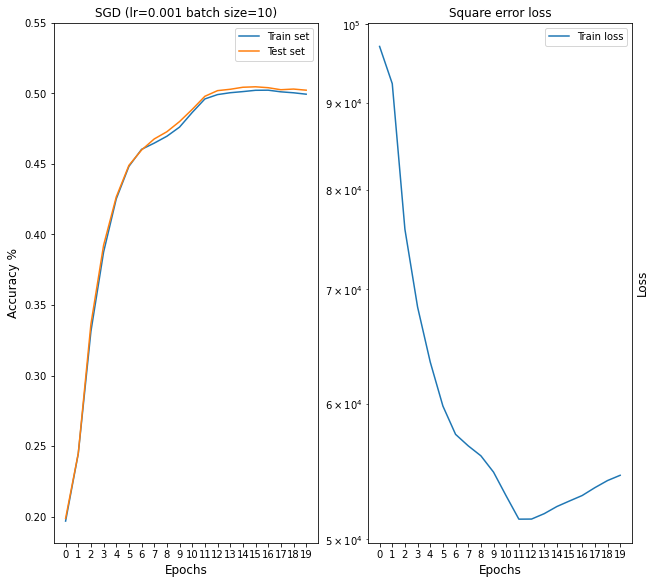

In [10]:
sgd(data_loader('GMMData') , lr=0.001, batch_size=10, epochs=20, to_plot=True)

  0%|          | 0/20 [00:00<?, ?it/s]

25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000
25000


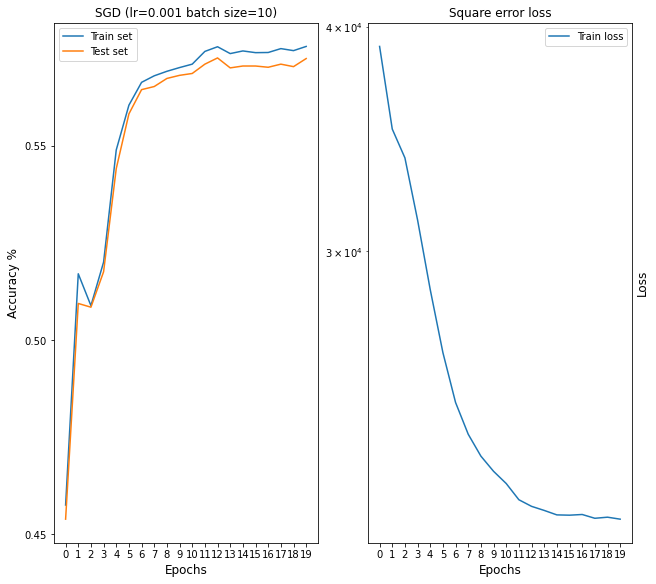

In [11]:
sgd(data_loader('PeaksData') , lr=0.001, batch_size=10, epochs=20, to_plot=True)